Full bytes with CRC:
0x8d 0x40 0x6b 0x90 0x20 0x15 0xa6 0x78 0xd4 0xd2 0x20 0xaa 0x4b 0xda 

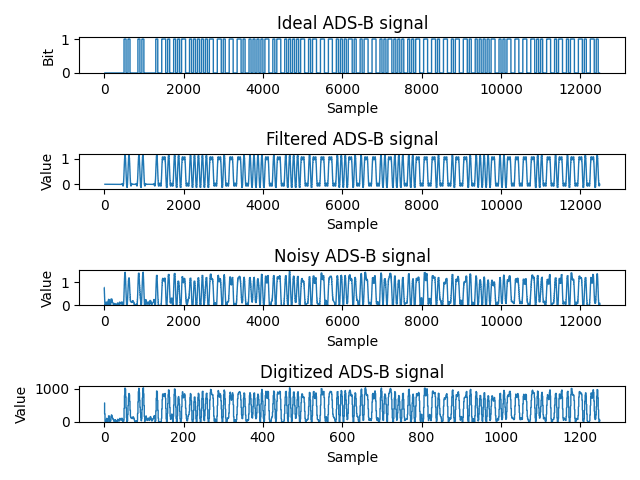

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from Functions.signal_generator import signal_start_pause_length, generate_ADSB, \
                                        digitize_signal, get_signal_energy, normalize_signal, \
                                        generate_fft_raw, get_signal_history, generate_ifft, \
                                        generate_fft_db, generate_ifft
from Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation
import Functions.plt_generator as plt_generator
import scipy.signal as signal
from ipywidgets import interact, IntText

#Configuration
amplitude = 1
data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])

#Generate and append CRC
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits
print("Full bytes with CRC:")
for i in full_bits:
    print(hex(i) + " ", end='')

#Generate and plot simulated ADS-B
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, full_bits)
#Digitize signal
digitized_signal, digitized_t = digitize_signal(noisy_signal, 100E6, 10E6, 1.4, 2**10)

plt.figure()
plt.subplot(4, 1, 1)
plt.stairs(ideal_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Bit')
plt.title('Ideal ADS-B signal')

plt.subplot(4, 1, 2)
plt.stairs(filtered_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Filtered ADS-B signal')

plt.subplot(4, 1, 3)
plt.stairs(noisy_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Noisy ADS-B signal')

plt.subplot(4, 1, 4)
plt.stairs(digitized_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Digitized ADS-B signal')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

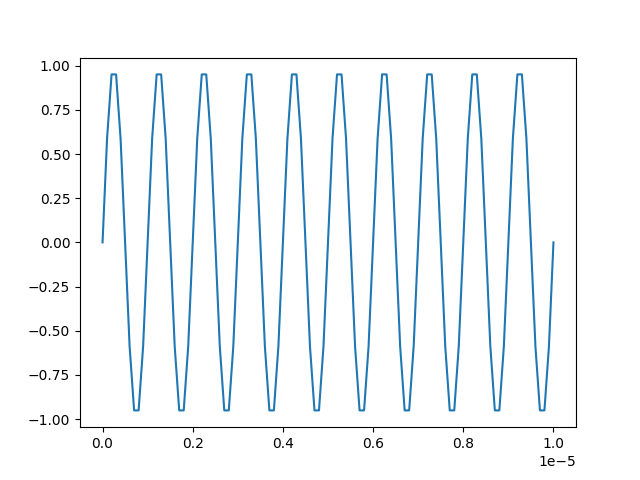

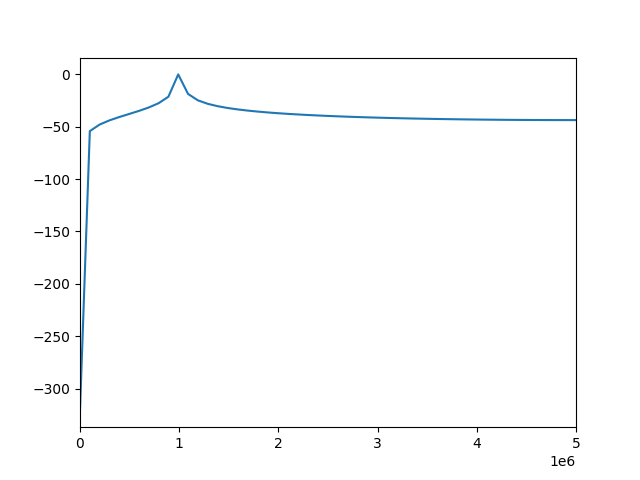

C:\Users\simon\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\simon\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


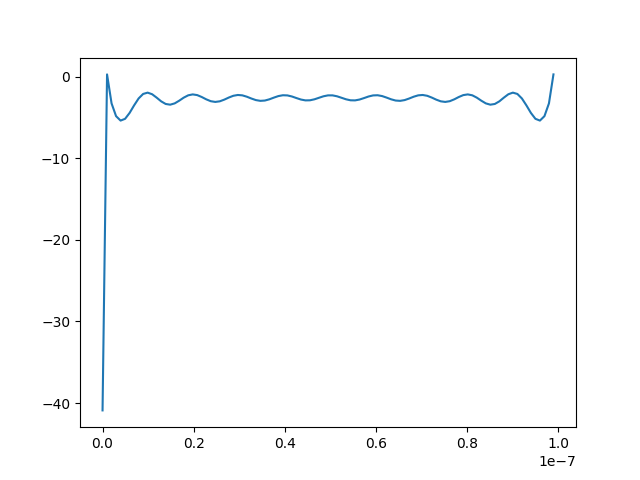

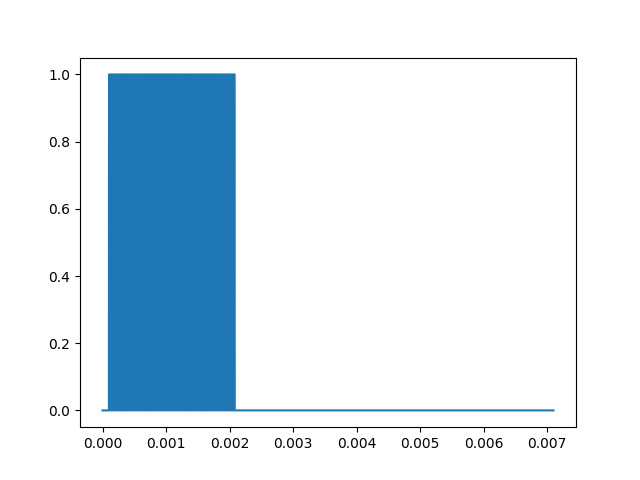

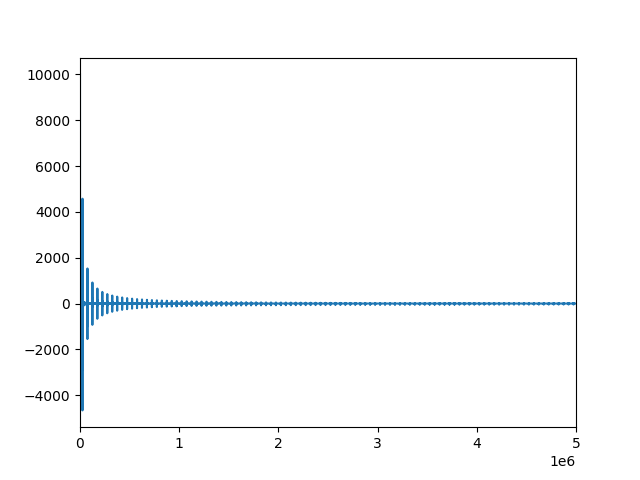

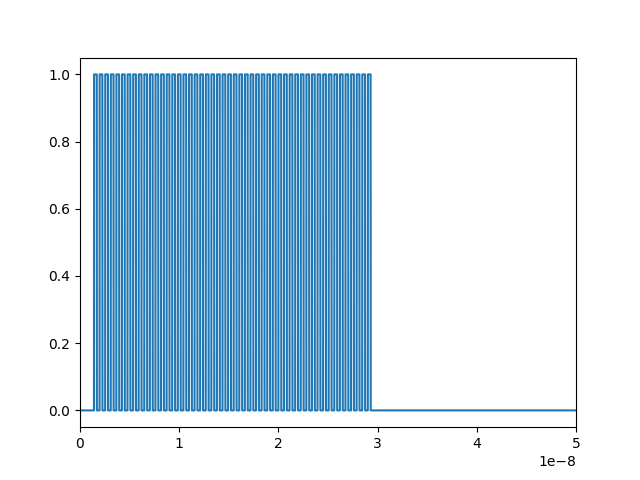

In [2]:
# Test of FFT functions
f_s_hz = 1e6
fd_hz = 10e6
duration_s = 1e-5

t = np.arange(0, duration_s, 1 / fd_hz)
sine = np.sin(2 * np.pi * f_s_hz * t)
plt.figure()
plt.plot(t, sine)
plt.show()

sine_fft_x, sine_fft_y = generate_fft_db(sine, fd_hz)
sine_ifft_x, sine_ifft_y = generate_ifft(sine_fft_y, fd_hz)

plt.figure()
plt.plot(sine_fft_x, sine_fft_y)
plt.xlim([0, fd_hz / 2])
plt.show()

plt.figure()
plt.plot(sine_ifft_x/fd_hz/fd_hz, sine_ifft_y)
# plt.xlim([0, fd_hz / 2])
plt.show()

square = np.zeros(1000)
for i in range(50):
    square = np.concatenate((square, np.ones(200), np.zeros(200)))
square = np.concatenate((square, np.zeros(50000)))

t = np.arange(0, len(square)/fd_hz, 1 / fd_hz)[:len(square)]
plt.figure()
plt.plot(t, square)
plt.show()

square_fft_x, square_fft_y = generate_fft_raw(square, fd_hz)
square_ifft_x, square_ifft_y = generate_ifft(square_fft_y, fd_hz)

plt.figure()
plt.plot(square_fft_x, square_fft_y)
plt.xlim([0, fd_hz / 2])
plt.show()

plt.figure()
plt.plot(square_ifft_x/fd_hz/fd_hz, square_ifft_y)
plt.xlim([0, 0.5e-7])
plt.show()

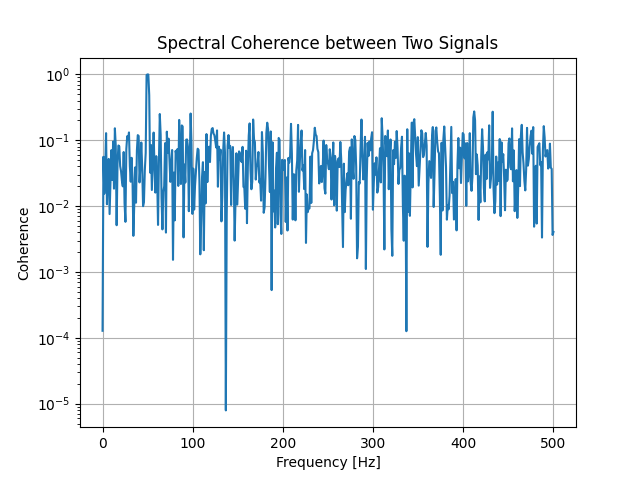

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence

# Generate sample signals
fs = 1000  # Sampling frequency in Hz
t = np.linspace(0, 10, fs * 10, endpoint=False)  # Time vector

# Create two signals
# Signal 1: Sine wave at 50 Hz with some noise
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.random.normal(size=len(t))

# Signal 2: Sine wave at 50 Hz and 120 Hz with some noise
y = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t) + 0.5 * np.random.normal(size=len(t))

# Calculate coherence
f, Cxy = coherence(x, y, fs=fs, nperseg=1024)

# Plot the coherence
plt.figure()
plt.semilogy(f, Cxy)
plt.title('Spectral Coherence between Two Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.grid()
plt.show()


In [4]:

fd_hz = 10e6
padding_scale = 3

def plot_sample_fft(preambule_type: int, sample_1: int, sample_2: int):
    preambule = preambule_list[preambule_type]
    mask_length = len(preambule.get_coefficients())

    if((sample_1 < mask_length) or (sample_2 < mask_length)):
        print(f"Sample too small, must be at least {mask_length}")
        return

    signal_range = get_signal_history(digitized_signal, sample_1, mask_length)
    fft_f_padded, fft_s_padded = generate_fft_db(signal_range, fd_hz, len(signal_range) * padding_scale)
    fft_f, fft_s = generate_fft_db(signal_range, fd_hz)

    signal_range_2 = get_signal_history(digitized_signal, sample_2, mask_length)
    fft_f_padded_2, fft_s_padded_2 = generate_fft_db(signal_range_2, fd_hz, len(signal_range_2) * padding_scale)
    fft_f_2, fft_s_2 = generate_fft_db(signal_range_2, fd_hz)

    f_cutoff = 2e6
    filter_order = 4
    filter_b, filter_a = signal.butter(filter_order, f_cutoff / (fd_hz / 2), btype="low", analog=False)
    digitized_ideal, digitized_ideal_t = digitize_signal(ideal_signal, 100E6, 10E6, 1.4, 2**10)
    ideal_range = get_signal_history(digitized_ideal, sample_1, mask_length)
    fft_ideal_f_hz, fft_ideal_s_db = generate_fft_db(ideal_range, fd_hz, 1000)
    fft_ideal_raw_f, fft_ideal_raw_s = generate_fft_raw(ideal_range, fd_hz, 1000)
    ideal_ifft_f_hz, ideal_ifft_s_db = generate_ifft(fft_ideal_raw_s, fd_hz)
    # ideal_ifft_f_hz, ideal_ifft_s_db = generate_ifft(fft_ideal_raw_s, fd_hz)

    fft_range_1_raw_f, fft_range_1_raw_s = generate_fft_raw(signal_range, fd_hz, 1000)
    ifft_range_1_f_hz, ifft_range_1_s_db = generate_ifft(fft_range_1_raw_s, fd_hz)
    fft_range_2_raw_f, fft_range_2_raw_s = generate_fft_raw(signal_range_2, fd_hz, 1000)
    ifft_range_2_f_hz, ifft_range_2_s_db = generate_ifft(fft_range_2_raw_s, fd_hz)

    plt.figure()
    plt.plot(ideal_range)
    plt.title("Ideal range")
    plt.xlabel("f, hz")
    plt.ylabel("s, dB")
    plt.show()

    plt.figure()
    plt.plot(fft_ideal_f_hz, fft_ideal_s_db)
    plt.xlim([0, fd_hz / 2])
    plt.ylim([-40, max(fft_ideal_s_db)])
    plt.title("FFT ideal")
    plt.xlabel("f, hz")
    plt.ylabel("s, dB")
    plt.show()

    plt.figure()
    plt.plot(ideal_ifft_s_db)
    # plt.xlim([0, fd_hz / 2])
    plt.title("IFFT ideal")
    plt.xlabel("f, hz")
    plt.ylabel("s, dB")
    plt.show()

    corr = preambule.get_correlation(digitized_signal, Correlation.Basic)

    w, h = signal.freqz(filter_b, filter_a)
    frequencies = w * fd_hz / (2 * np.pi)

    # Plot signal
    plt.figure()
    plt.stairs(corr, label="Correlation", baseline=None)
    plt.scatter(sample_1,
                corr[sample_1],
                marker='x', color='red', label="Sample 1")
    plt.scatter(sample_2, corr[sample_2], marker='x', color='green', label="Sample 2")
    plt.title(preambule.get_name() + " preambule correlation")
    plt.legend()
    plt.show()

    # Plot FFT of two points
    plt.figure(figsize=(10,5))
    plt.plot(fft_f, fft_s, label='Originalus')
    plt.plot(fft_f_padded, fft_s_padded, label='Paddintas')
    plt.plot(fft_ideal_f_hz, fft_ideal_s_db, label='Idealus')
    # plt.plot(frequencies,20 * np.log10(abs(h)), color="red")
    plt.title(f"FFT from point {str(sample_1)}")
    plt.tight_layout()
    plt.legend()
    plt.show()

    # plt.subplot(122)
    plt.figure()
    plt.plot(fft_f_2, fft_s_2, label='Originalus')
    plt.plot(fft_f_padded_2, fft_s_padded_2, label='Paddintas')
    plt.xlabel('f, Hz')
    plt.ylabel('Sa, dB')
    plt.xlim([0, fd_hz/2])
    plt.title(f"FFT from point {str(sample_2)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# preambule_type_widget = IntText(value=0, description="Preambule mask type")
# sample_1_widget = IntText(value=signal_start_pause_length + preambule_list[Preambule.Ideal.value].get_expected_maximum(), description="FFT index of Basic mask 1")
# sample_2_widget = IntText(value=signal_start_pause_length + preambule_list[Preambule.Ideal.value].get_expected_maximum()*2, description="FFT index of Basic mask 2")

# interact(plot_sample_fft, preambule_type=preambule_type_widget, sample_1=sample_1_widget, sample_2=sample_2_widget)

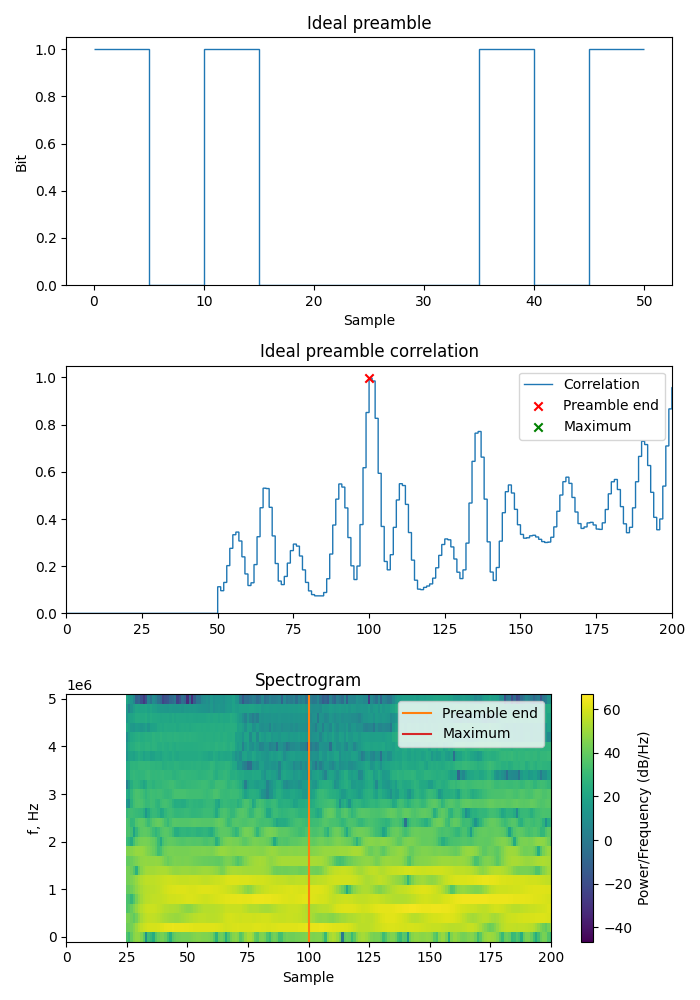

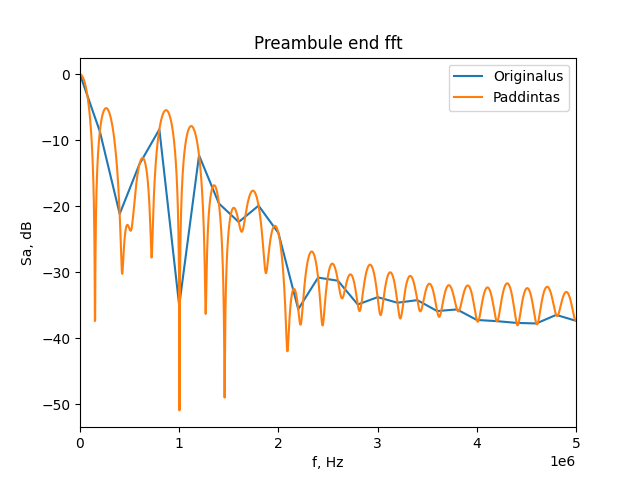

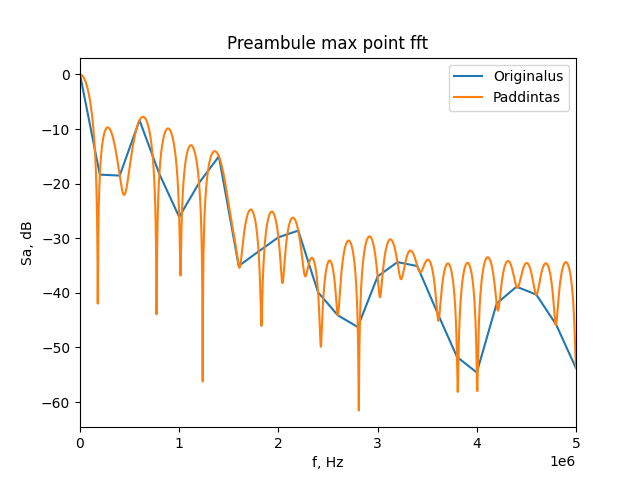

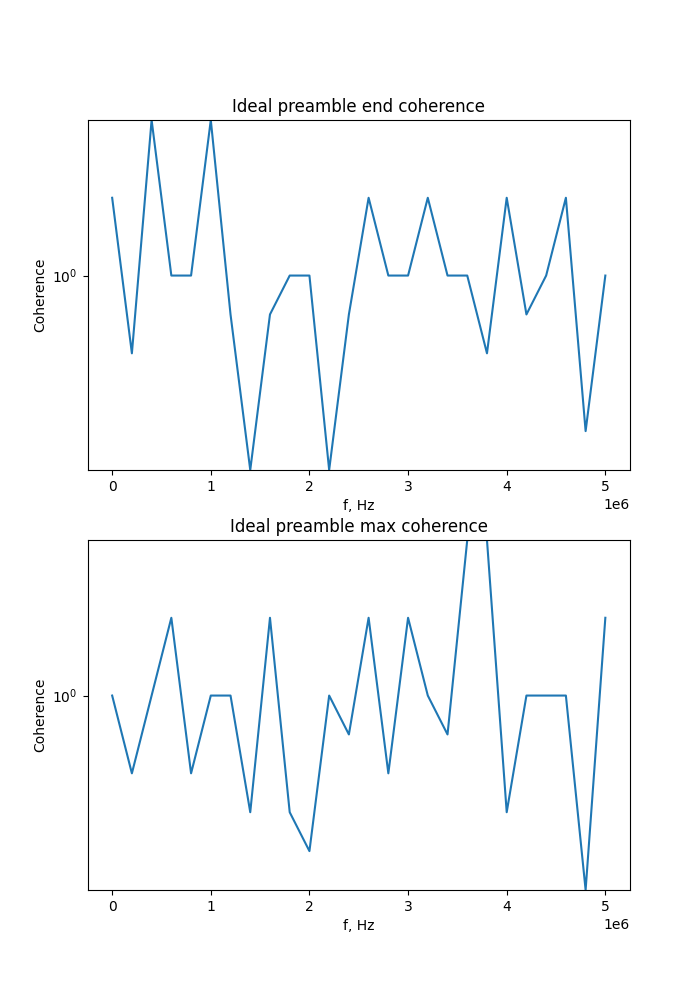

In [6]:
# for preambule in preambule_list:
for preambule in preambule_list[0:1]:
    expected_maximum_point_x = signal_start_pause_length + preambule.get_expected_maximum()
    curr_preambule_corr = preambule.get_correlation(digitized_signal, Correlation.Basic)
    curr_energy = get_signal_energy(digitized_signal, len(preambule.get_coefficients()))
    normalize_signal(curr_preambule_corr)
    max_idx = np.argmax(curr_preambule_corr)
    # Max and end points fft correlation
    signal_range_max = get_signal_history(digitized_signal, max_idx, len(preambule.get_coefficients()))
    corr_max_fft_f_padded, corr_max_fft_s_padded = generate_fft_db(signal_range_max, fd_hz, len(digitized_signal) * padding_scale)
    corr_max_fft_f, corr_max_fft_s = generate_fft_db(signal_range_max, fd_hz)

    signal_range_end = get_signal_history(digitized_signal, expected_maximum_point_x, len(preambule.get_coefficients()))
    preambule_end_fft_f_padded, preambule_end_fft_s_padded = generate_fft_db(signal_range_end, fd_hz, len(digitized_signal) * padding_scale)
    preambule_end_fft_f, preambule_end_fft_s = generate_fft_db(signal_range_end, fd_hz)

    preamble_end_coherence_f, preamble_end_coherence_s = signal.coherence(signal_range_end, preambule.get_coefficients(), fs=fd_hz)
    corr_max_coherence_f, corr_max_coherence_s = signal.coherence(signal_range_max, preambule.get_coefficients(), fs=fd_hz)

    # Preambule plot
    plt.figure(figsize=(7,10))
    plt.subplot(311)
    plt.stairs(preambule.get_coefficients(), baseline=None)
    plt.xlabel('Sample')
    plt.ylabel('Bit')
    plt.title(f"{preambule.get_name()} preamble")

    # Correlation and energy plot
    plt.subplot(312)
    plt.stairs(curr_preambule_corr, label="Correlation", baseline=None)
    plt.scatter(expected_maximum_point_x,
                curr_preambule_corr[expected_maximum_point_x],
                marker='x', color='red', label="Preamble end")
    plt.scatter(max_idx, curr_preambule_corr[max_idx], marker='x', color='green', label="Maximum")
    plt.title(preambule.get_name() + " preamble correlation")
    plt.legend()
    plt.xlim([0, 200])

    nperseg = len(preambule.get_coefficients())
    f, t_spectrogram, Sxx = signal.spectrogram(digitized_signal, 1, nperseg=nperseg, noverlap=nperseg-1)
    f_spectrogram = f * fd_hz
    plt.subplot(313)
    plt.pcolormesh(t_spectrogram, f_spectrogram, 10 * np.log10(Sxx))
    plt.ylabel('f, Hz')
    plt.xlabel('Sample')
    plt.title('Spectrogram')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.axvline(expected_maximum_point_x, color='tab:orange', label='Preamble end')
    plt.axvline(max_idx, color='tab:red', label='Maximum')
    plt.legend()
    plt.xlim([0, 200])
    plt.tight_layout()
    plt.show()

    #FFT plots
    plt_generator.plot_fft("Preambule end fft", fd_hz, preambule_end_fft_f, preambule_end_fft_s, 'Originalus',
                        preambule_end_fft_f_padded, preambule_end_fft_s_padded, 'Paddintas')
    plt_generator.plot_fft("Preambule max point fft", fd_hz, corr_max_fft_f, corr_max_fft_s, 'Originalus',
                        corr_max_fft_f_padded, corr_max_fft_s_padded, 'Paddintas')

    plt.figure(figsize=(7,10))
    plt.subplot(211)
    plt.semilogy(preamble_end_coherence_f, preamble_end_coherence_s)
    plt.title(f"{preambule.get_name()} preamble end coherence")
    plt.xlabel('f, Hz')
    plt.ylabel('Coherence')
    plt.subplot(212)
    plt.semilogy(corr_max_coherence_f, corr_max_coherence_s)
    plt.title(f"{preambule.get_name()} preamble max coherence")
    plt.xlabel('f, Hz')
    plt.ylabel('Coherence')
    plt.show()
